In [ ]:
# Jostautas Sakas 2110617 classes=["Car", "Dragonfly", "Ice cream"]
# Most of the commented code is needed only for model training.
# To test the latest succesfully trained model, run the code as is.

In [ ]:
pip install openimages

In [2]:
# Import dependencies

import numpy as np
import math
import os
from pathlib import Path
from openimages.download import download_dataset
import torch
from torch import nn
import torch.optim as optim
import torchvision
from torch.autograd import Variable
from torchvision import datasets
from torchvision import models
from torchvision.transforms import ToTensor
from torchvision.transforms import transforms
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torch.utils.data import dataset
from skimage import io
from skimage.transform import resize
from skimage.color import gray2rgb
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import random

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# Download images

train_data_dir = "train_data"
test_data_dir = "test_data"
number_of_train_samples = 300
number_of_test_samples = 50
classes = ["Car", "Dragonfly", "Ice cream"]
class_ids = [0, 1, 2]

# if not os.path.exists(train_data_dir):
#     os.makedirs(train_data_dir)
#     print("Downloading is starting...")
#     download_dataset(train_data_dir, classes, limit=number_of_train_samples)
if not os.path.exists(test_data_dir):
    os.makedirs(test_data_dir)
    print("Downloading is starting...")
    download_dataset(test_data_dir, classes, limit=number_of_test_samples)

In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
# train_dataset = datasets.ImageFolder(root='/content/'+train_data_dir, transform=transform)
# train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=30, shuffle=True)
test_dataset = datasets.ImageFolder(root='/content/'+test_data_dir, transform=transform)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=25, shuffle=True)

In [22]:
# First test model:
# class MyModel(nn.Module):
#     def __init__(self):
#         super(MyModel, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.fc1 = nn.Linear(in_features=64*56*56, out_features=512)
#         self.fc2 = nn.Linear(in_features=512, out_features=3)
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         x = self.pool(self.relu(self.conv1(x)))
#         x = self.pool(self.relu(self.conv2(x)))
#         x = x.view(-1, 64*56*56)  # Flatten the tensor
#         x = self.fc1(x)
#         x = self.fc2(x)
#         return x

In [24]:
# Second test model (added third conv and linear layers):
# class MyModel(nn.Module):
#     def __init__(self):
#         super(MyModel, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
#         self.fc1 = nn.Linear(in_features=128 * 28 * 28, out_features=512)
#         self.fc2 = nn.Linear(in_features=512, out_features=128)
#         self.fc3 = nn.Linear(in_features=128, out_features=3)
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         x = self.pool(self.relu(self.conv1(x)))
#         x = self.pool(self.relu(self.conv2(x)))
#         x = self.pool(self.relu(self.conv3(x)))
#         x = x.view(-1, 128 * 28 * 28)  # Flatten the tensor
#         x = self.fc1(x)
#         x = self.fc2(x)
#         x = self.fc3(x)
#         return x

In [12]:
# Final model (added ReLU to the linear leayers)

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(in_features=128 * 28 * 28, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)  # Flatten the tensor
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
model = MyModel().to(device)

model.load_state_dict(torch.load('custom_model_test2.pth'))#, map_location=torch.device(device)))
model.eval()

In [ ]:
# Training loop

# loss_fn = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# num_epochs = 16

# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0
#     for images, labels in train_data_loader:
#         images, labels = images.to(device), labels.to(device)
#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = loss_fn(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()
#     print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_data_loader)}, Simple Loss: {loss}")

In [ ]:
# First test model:
# Epoch 1, Loss: 5.5626517057418825, Simple Loss: 0.980798602104187
# Epoch 2, Loss: 0.8941581547260284, Simple Loss: 0.74949049949646
# Epoch 3, Loss: 0.681213429570198, Simple Loss: 0.6625829339027405
# Epoch 4, Loss: 0.4924980809291204, Simple Loss: 0.3606448471546173
# Epoch 5, Loss: 0.3182867040236791, Simple Loss: 0.2423921376466751
# Epoch 6, Loss: 0.1683565596739451, Simple Loss: 0.141479954123497
# Epoch 7, Loss: 0.0937744672720631, Simple Loss: 0.08343930542469025
# Epoch 8, Loss: 0.06102293053021034, Simple Loss: 0.06276926398277283
# Epoch 9, Loss: 0.041815626248717305, Simple Loss: 0.01190758217126131
# Epoch 10, Loss: 0.015189967157008747, Simple Loss: 0.0024253125302493572
# Epoch 11, Loss: 0.004477006150409579, Simple Loss: 0.004373690579086542
# Epoch 12, Loss: 0.0030538336858929446, Simple Loss: 0.001021948759444058
# Epoch 13, Loss: 0.0017294603089491527, Simple Loss: 0.0008339631021954119
# Epoch 14, Loss: 0.0013679310708539561, Simple Loss: 0.0024695058818906546
# Epoch 15, Loss: 0.0012365301362782096, Simple Loss: 0.0006492625107057393
# Epoch 16, Loss: 0.0010941352675824115, Simple Loss: 0.0012637117179110646

# Second test model:
# Epoch 1, Loss: 1.270589788754781, Simple Loss: 1.343250036239624
# Epoch 2, Loss: 0.6761273324489594, Simple Loss: 0.5135650038719177
# Epoch 3, Loss: 0.49642785886923474, Simple Loss: 0.3031591475009918
# Epoch 4, Loss: 0.4750068520506223, Simple Loss: 0.4651206433773041
# Epoch 5, Loss: 0.3363905241092046, Simple Loss: 0.21274520456790924
# Epoch 6, Loss: 0.3219044953584671, Simple Loss: 0.4233313202857971
# Epoch 7, Loss: 0.3038144481678804, Simple Loss: 0.182656928896904
# Epoch 8, Loss: 0.20099110677838325, Simple Loss: 0.0672178715467453
# Epoch 9, Loss: 0.12321858294308186, Simple Loss: 0.15959559381008148
# Epoch 10, Loss: 0.16045663133263588, Simple Loss: 0.4182799756526947
# Epoch 11, Loss: 0.11733065464844307, Simple Loss: 0.07591135799884796
# Epoch 12, Loss: 0.12620178026457626, Simple Loss: 0.11196311563253403
# Epoch 13, Loss: 0.1918420805906256, Simple Loss: 0.013588270172476768
# Epoch 14, Loss: 0.13234935045863191, Simple Loss: 0.1672002375125885
# Epoch 15, Loss: 0.04116323278285563, Simple Loss: 0.03305630385875702
# Epoch 16, Loss: 0.011927442987992738, Simple Loss: 0.0011916917283087969

# Final model:
# Epoch 1, Loss: 1.0265759785970052, Simple Loss: 1.0306379795074463
# Epoch 2, Loss: 0.6657158484061559, Simple Loss: 0.43874305486679077
# Epoch 3, Loss: 0.5857181365291277, Simple Loss: 0.49914127588272095
# Epoch 4, Loss: 0.41034142722686134, Simple Loss: 0.18587665259838104
# Epoch 5, Loss: 0.3103736326098442, Simple Loss: 0.43646240234375
# Epoch 6, Loss: 0.2666563960413138, Simple Loss: 0.111669160425663
# Epoch 7, Loss: 0.19264048971235753, Simple Loss: 0.1338711678981781
# Epoch 8, Loss: 0.1264755527799328, Simple Loss: 0.02713269367814064
# Epoch 9, Loss: 0.15696180298303564, Simple Loss: 0.10667965561151505
# Epoch 10, Loss: 0.058145968290045855, Simple Loss: 0.25064125657081604
# Epoch 11, Loss: 0.0579393676482141, Simple Loss: 0.024215327575802803
# Epoch 12, Loss: 0.019172424691108365, Simple Loss: 0.013169738464057446
# Epoch 13, Loss: 0.005544621202473839, Simple Loss: 0.0025857873260974884
# Epoch 14, Loss: 0.0034405063595234725, Simple Loss: 0.0002751107094809413
# Epoch 15, Loss: 0.0009279136953409761, Simple Loss: 0.0022798862773925066
# Epoch 16, Loss: 0.00042111391315605335, Simple Loss: 0.0002649851667229086

In [ ]:
# model.eval()
# torch.save(model.state_dict(), 'custom_model_final.pth')

In [26]:
def class_statistics(truth, predictions, threshold):
    predictions_binary = (predictions > threshold).astype(int)
    accuracy = accuracy_score(truth, predictions_binary)
    recall = recall_score(truth, predictions_binary)
    precision = precision_score(truth, predictions_binary)
    f1 = f1_score(truth, predictions_binary)
    cm = confusion_matrix(truth, predictions_binary)

    return {
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision,
        'f1': f1,
        'confusion_matrix': cm
    }

def calculate_probability(probabilities, class_id, label_arr, class_label): # (probabilities: [n_samples, n_classes], class_id: int, label_arr: [n_samples], class_label: int) -> [(float), (bool)]
    return [(probabilities[i][class_id],
             float(label_arr[i] == class_label)) for i in range(len(label_arr))]

def get_probabilities(array):
    return [probability for probability, _ in array]

def get_truths(arr):
    return [truth for _, truth in arr]

def calculate_statistics(probabilities, threshold):
  truth_list = get_truths(probabilities)
  probabilities_list = get_probabilities(probabilities)

  return class_statistics(np.array(truth_list),
                           np.array(probabilities_list),
                           threshold)
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()


In [27]:
thresholds = [0.8, 0.8, 0.8]


Statistics for Car:
Accuracy: 0.9466666666666667
Recall: 1.0
Precision: 0.8620689655172413
F1 Score: 0.9259259259259259


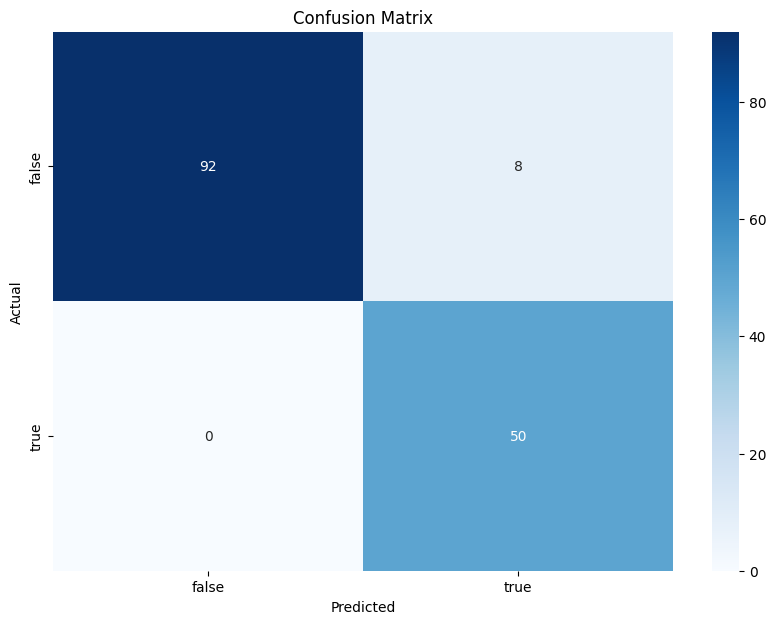


Statistics for Dragonfly:
Accuracy: 0.9933333333333333
Recall: 1.0
Precision: 0.9803921568627451
F1 Score: 0.99009900990099


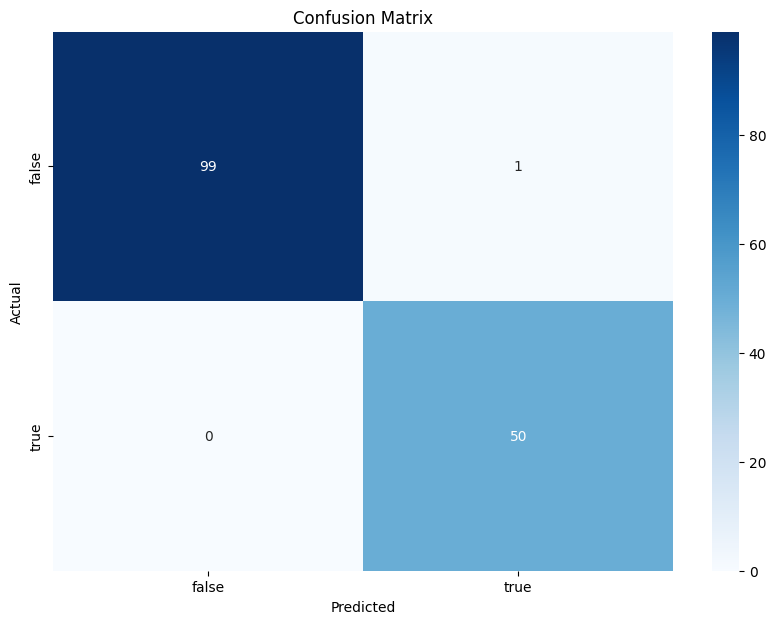


Statistics for Ice cream:
Accuracy: 0.9933333333333333
Recall: 1.0
Precision: 0.9803921568627451
F1 Score: 0.99009900990099


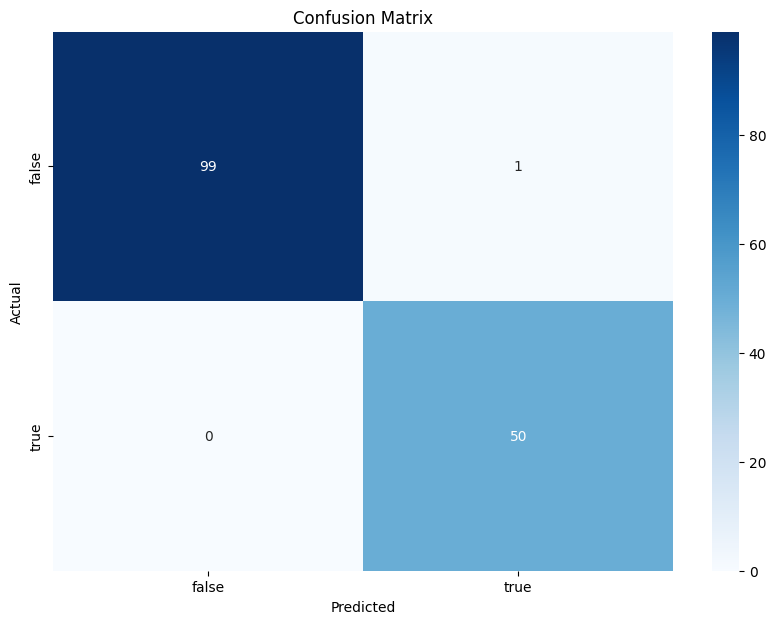

In [28]:
def print_statistics(label, results):
    print(f"\nStatistics for {label}:")
    print(f"Accuracy: {results['accuracy']}")
    print(f"Recall: {results['recall']}")
    print(f"Precision: {results['precision']}")
    print(f"F1 Score: {results['f1']}")

class_probabilities = {label: [] for label in classes}

for images, labels in test_data_loader:
  images, labels = images.to(device), labels.to(device)
  outputs = model(images)
  probabilities = torch.sigmoid(outputs).detach().cpu().numpy()
  labels_array = labels.cpu().numpy()

  for label, class_id in zip(classes, class_ids):
    class_probabilities[label].extend(calculate_probability(probabilities, class_id, labels_array, classes.index(label)))

for label, threshold in zip(classes, thresholds):
  results = calculate_statistics(class_probabilities[label], threshold)
  print_statistics(label, results)
  plot_confusion_matrix(results['confusion_matrix'], class_names=['false', 'true'])

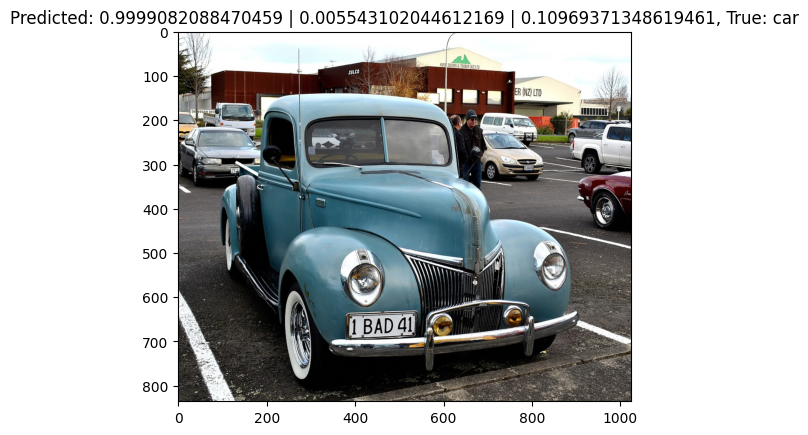

In [19]:
def predict_and_display(image, model, transform):
    model.eval()
    image_transformed = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(image_transformed)
    probabilities = torch.sigmoid(outputs[0])
    binary_probabilities = probabilities.cpu().numpy()
    return binary_probabilities

chosen_class = "car"
chosen_class_idx = test_dataset.class_to_idx[chosen_class]

chosen_class_images = [img_path for img_path, label in test_dataset.samples if label == chosen_class_idx]

selected_image_path = random.choice(chosen_class_images)

selected_image = Image.open(selected_image_path).convert('RGB')

predicted_class = predict_and_display(selected_image, model, transform)
true_class = test_dataset.classes[chosen_class_idx]

plt.imshow(selected_image)
plt.title(f"Predicted: {predicted_class[class_ids[0]]} | {predicted_class[class_ids[1]]} | {predicted_class[class_ids[2]]}, True: {true_class}")
plt.show()